See documentation on how to use this colab here: https://docs.google.com/a/google.com/document/d/1haumBiP-GAaNI1HAf2jWUM1usnin-atI-DUH6hRr6IM/edit?usp=sharing

In [7]:
#@title Input { display-mode: "form", run: "auto" }

import datetime
import re
import string

from colabtools import shell, dremel, magicfunc, nvd3, js, outputformat, interactive_table, interactive_forms
import math
import pandas
import numpy
import matplotlib.pyplot as plt
from matplotlib import pylab as pl
from scipy.stats import t

## turn on translation of enums as string (default is they are shown as integers)
dremel.ENABLE_STRING_ENUM = True

## set the accounting group for dremel to play-commerce-analytics
dremel.SetAccountingGroup('play-commerce-data-readers')
dremel.SetDremelCredentials()

## set the materialize owners group to play-commerce-analytics
dremel.SetMaterializeOwnerGroup('play-commerce-data-readers')
dremel.SetMaterializeOverwrite(True)

## use googleSQL
dremel.SetLanguage('DremelSQL')

## setting printModel to 1; i.e. removing in-cell vertical scrollbars. 
ip = get_ipython()
ip.events.register('pre_run_cell', outputformat.no_vertical_scrollbar)

def convertToDremelDateStr(date):
  return datetime.datetime.strptime(date, '%Y-%m-%d').date().strftime("%Y%m%d")

target_ids = "12631590,12631589" #@param
start_date = "2017-05-06" #@param {type:"date"}
end_date = "2017-05-12" #@param {type:"date"}
ip_country = "All" #@param

# Validate Target IDs
pattern = re.compile("\d+")
target_ids_arr = []
for target_id in string.split(target_ids, ","):
  target_id = string.strip(target_id)
  if len(target_id) == 0:
    continue
  m = pattern.match(target_id)
  if not m or len(m.group(0)) != len(target_id):
    print "WARNING: target ID \'" + target_id + "' is not valid and will be ignored."
    continue
  target_ids_arr.append(int(target_id))
  
# Validate Dates
if (end_date < start_date):
  raise Exception("End date cannot be less than start date!")
start_end_date_string = "{" + convertToDremelDateStr(start_date) + ".." + convertToDremelDateStr(end_date) + "}"

# change date format
start_date_wo_dash = convertToDremelDateStr(start_date)
end_date_wo_dash = convertToDremelDateStr(end_date)
start_end_date_string = "{" + start_date_wo_dash + ".." + end_date_wo_dash + "}"
#start_end_date_string = "last14days"

# ip_country parameter
ip_countries = ""
if (ip_country == "All"):
  country_filter = ""
else:
  country_filter = "and ip_country in ('" + ip_country + "')"

In [8]:
#@title Function Library {display-mode: "form", vertical-output: true}
%%substitute_globals
target_id_arr = {target_ids_arr}

def GetSeriesForGroup(index_series, table):
  series_num = table.groupby('date')['numerator'].sum()
  series_denom = table.groupby('date')['denominator'].sum()
  series = []
  for i in index_series:
    try:
      num = series_num[index_series.index(i)]
      denom = series_denom[index_series.index(i)]
      ratio = float(num) / denom
    except IndexError:
      print "WARNING! Missing Date:", i
      ratio = 0.0
    series.append(ratio)
  return series;

def PlotSeries(index_series, ctr_series, exp_series_arr):
  data = {'date': index_series,
          '{0} (control)'.format(target_id_arr[0]): ctr_series}
  labels = ['{0} (control)'.format(target_id_arr[0])]
  for i in range(1, len(target_id_arr)):
    target_id = str(target_id_arr[i])
    data[target_id] = exp_series_arr[i - 1]
    labels.append(target_id)

  df=pandas.DataFrame(data, index=index_series, columns=labels)
  df.plot()

def PrintDailyTimeSeries(date_series, target_id_series, num_series, denom_series):
  initial_table=pandas.DataFrame({'date': date_series.tolist(),
                                  'target_id': target_id_series.tolist(),
                                  'numerator': num_series.tolist(),
                                  'denominator': denom_series.tolist()},
                                  columns=['date','target_id','numerator','denominator'])
  
  index_series = numpy.unique(date_series).tolist()
  
  control_table = (
      initial_table[
          ['date', 'numerator', 'denominator']
      ][initial_table.target_id == target_id_arr[0]])
  ctr_series = GetSeriesForGroup(index_series, control_table)

  experiment_tables = []
  for i in range(1, len(target_id_arr)):
    experiment_tables.append(
      initial_table[['date', 'numerator', 'denominator']
                   ][initial_table.target_id == target_id_arr[i]])
      
  exp_series_arr = [GetSeriesForGroup(index_series, table)
                    for table in experiment_tables]

  # plot daily series
  for i in range(1, len(target_id_arr)):
    exp_series = exp_series_arr[i - 1]
    ratio = exp_series[-1] / ctr_series[-1] - 1.0
    ratio_pct = round(ratio*100,2)
    print "Cumulative uplift for group {0}: {1}%".format(
      target_id_arr[i], ratio_pct)
  PlotSeries(index_series, ctr_series, exp_series_arr)

def PrintCumulativeTimeSeries(date_series, target_id_series, num_series, denom_series):
  initial_table=pandas.DataFrame({'date': date_series.tolist(),
                                  'target_id': target_id_series.tolist(),
                                  'numerator': num_series.tolist(),
                                  'denominator': denom_series.tolist()},
                                  columns=['date','target_id','numerator','denominator'])
  
  index_series = numpy.unique(date_series).tolist()
  
  control_table = (
      initial_table[
          ['date', 'numerator', 'denominator']
      ][initial_table.target_id == target_id_arr[0]])
  ctr_series = GetSeriesForGroup(index_series, control_table)

  experiment_tables = []
  for i in range(1, len(target_id_arr)):
    experiment_tables.append(
      initial_table[['date', 'numerator', 'denominator']
                   ][initial_table.target_id == target_id_arr[i]])
      
  exp_series_arr = [GetSeriesForGroup(index_series, table)
                    for table in experiment_tables]

  # plot cumulative series
  cum_ctr_series = numpy.cumsum(ctr_series)
  cum_exp_series_arr = [numpy.cumsum(exp_series)
                        for exp_series in exp_series_arr]
  for i in range(1, len(target_id_arr)):
    cum_exp_series = cum_exp_series_arr[i - 1]
    cum_ratio = cum_exp_series[-1] / cum_ctr_series[-1] - 1.0
    cum_ratio_pct = round(cum_ratio*100,2)
    print "Cumulative uplift for group {0}: {1}%".format(
      target_id_arr[i], cum_ratio_pct)
  PlotSeries(index_series, cum_ctr_series, cum_exp_series_arr)

def JackknifeStandardErrorRatioMetricOneSample(bucket_num, bucket_denom):
  if len(bucket_num) != len(bucket_denom):
    raise ValueError("""control_buckets and experiment_buckets are not the
    same length""")

  n_buckets = len(bucket_num)
  num_sum = sum(bucket_num)
  denom_sum = sum(bucket_denom)
  global_ratio = float(num_sum) / float(denom_sum)

  jackknife_sum_squares = 0.0

  for i in range(n_buckets):
    jackknife_bucket = float(num_sum - bucket_num[i]) / float(denom_sum - bucket_denom[i])
    jackknife_sum_squares += (jackknife_bucket - global_ratio) ** 2
  
  jackknife_sum_squares = float(jackknife_sum_squares)
  n_buckets = float(n_buckets)
  metric_se = math.sqrt(jackknife_sum_squares * ((n_buckets - 1) / n_buckets))
  return global_ratio, metric_se

def CreateTConfidenceInterval(overall_metric,
                              metric_se,
                              n_buckets,
                              confidence_level=0.05):
  t_rv = t(n_buckets - 1)
  t_statistic = t_rv.ppf(1 - confidence_level / 2.0)

  upper_bound = overall_metric + t_statistic * metric_se
  lower_bound = overall_metric - t_statistic * metric_se
  return lower_bound, upper_bound

def ComputeRatioMetricWithCI(bucket_num, bucket_denom):
  if isinstance(bucket_num, pandas.Series):
    bucket_num = bucket_num.tolist()

  if isinstance(bucket_denom, pandas.Series):
    bucket_denom = bucket_denom.tolist()

  if len(bucket_num) != len(bucket_denom):
    raise ValueError("""numerator and denominator buckets
    are of different lengths""")
  
  n = len(bucket_num)
  metric, se = JackknifeStandardErrorRatioMetricOneSample(bucket_num,
                                                          bucket_denom)
  lower_bound, upper_bound = CreateTConfidenceInterval(metric, se, n)
  return metric, lower_bound, upper_bound

# calculate mean
def CalculateMean(data):
  n = len(data)
  sum = 0.0
  
  for i in range(n):
    sum += float(data[i])
  
  return sum/n

# calculate (sample) standard deviation
def CalculateSD(data):
  n = len(data)
  sumsquare = 0.0
  avg = CalculateMean(data)
  
  for i in range(n):
    sumsquare += (data[i] - avg) * (data[i] - avg)
    
  return math.sqrt(sumsquare/(n-1))

# run t-test (paired)
def OneSamplePairedTTest(experiment, control, sig_level=0.05):
  diff = list(numpy.array(experiment) - numpy.array(control))

  n = len(diff)
  t_rv = t(n - 1)
  t_statistics = t_rv.ppf(1 - sig_level / 2.0)
  
  avg = CalculateMean(diff)
  se = CalculateSD(diff) / math.sqrt(n)
  
  test = abs(avg/se)

  IsSignificant = False
  
  if (test >= t_statistics):
    IsSignificant = True
  
  return IsSignificant, avg, se, test, t_statistics
  
# calculate and print statistical significance
def PrintStatisticalSignificance(date_series, target_id_series, num_series, denom_series, sig_level=0.05):
  initial_table=pandas.DataFrame({'date': date_series.tolist(),
                                  'target_id': target_id_series.tolist(),
                                   'numerator': num_series.tolist(),
                                  'denominator': denom_series.tolist()},
                                  columns=['date','target_id','numerator','denominator']).sort(columns=['date','target_id'],ascending=[1,1])
  
  experiment_table = (
      initial_table[
          ['date','numerator','denominator']
      ][initial_table.target_id == target_id_arr[1]]).reset_index()
  control_table = (
      initial_table[
          ['date','numerator','denominator']
      ][initial_table.target_id == target_id_arr[0]]).reset_index() 
  
  experiment_series_num = pandas.Series(experiment_table.numerator).tolist()
  experiment_series_denom = pandas.Series(experiment_table.denominator).tolist()
  
  control_series_num = pandas.Series(control_table.numerator).tolist()
  control_series_denom = pandas.Series(control_table.denominator).tolist()
  
  experiment_series = []
  control_series = []
  
  for i in range(len(experiment_series_num)):
    exp_num = experiment_series_num[i]
    exp_denom = experiment_series_denom[i]
    
    ctr_num = control_series_num[i]
    ctr_denom = control_series_denom[i]
    
    exp_ratio = float(exp_num) / float(exp_denom)
    ctr_ratio = float(ctr_num) / float(ctr_denom)
    
    experiment_series.append(exp_ratio)
    control_series.append(ctr_ratio)
  
  IsSignificant, avg_metric, se_metric, ttest, t_statistic = OneSamplePairedTTest(experiment_series, control_series)
  if IsSignificant == True:
    print "Statistically significant"
  else:
    print "Statistically not significant"
  
  overall_avg_metric = sum(control_series_num) / len(control_series_denom)
  
  lower_bound = avg_metric - se_metric * t_statistic
  upper_bound = avg_metric + se_metric * t_statistic
  
  lower_bound_pct = int(lower_bound/overall_avg_metric * 1000000.0 ) / 10000.0
  upper_bound_pct = int(upper_bound/overall_avg_metric * 1000000.0 ) / 10000.0
  
  avg_metric_pct = int(avg_metric/overall_avg_metric * 1000000.0 ) / 10000.0
  
  print "Confidence interval: [" + str(lower_bound_pct) + "%," + str(upper_bound_pct) + "%]"   
  print "Average uplift: " + str(avg_metric_pct) + "%"

from matplotlib import gridspec

def getRatio(num, denom):
  return 0 if num == 0 else float(num) / float(denom)

def JackknifeStandardErrorDifferenceTwoRatios(
    exp_bucket_num, exp_bucket_denom,
    ctr_bucket_num, ctr_bucket_denom):

  if (len(exp_bucket_num) != len(exp_bucket_denom) and
      len(exp_bucket_num) != len(ctr_bucket_num) and
      len(exp_bucket_num) != len(ctr_bucket_denom)):
    raise ValueError('control_buckets and experiment_buckets not same length')
    
  n_buckets = len(ctr_bucket_num)
  
  ctr_num_sum = sum(ctr_bucket_num)
  ctr_denom_sum = sum(ctr_bucket_denom)
  ctr_ratio = getRatio(ctr_num_sum, ctr_denom_sum)
  
  exp_num_sum = sum(exp_bucket_num)
  exp_denom_sum = sum(exp_bucket_denom)
  exp_ratio = getRatio(exp_num_sum, exp_denom_sum)

  global_difference = exp_ratio - ctr_ratio

  jackknife_sum_squares = 0.0
  
  
  for i in range(n_buckets):
    jackknife_bucket = (
        getRatio(exp_num_sum - exp_bucket_num[i], exp_denom_sum - exp_bucket_denom[i]) -
        getRatio(ctr_num_sum - ctr_bucket_num[i], ctr_denom_sum - ctr_bucket_denom[i]))
    jackknife_sum_squares += (jackknife_bucket - global_difference) ** 2
  
  jackknife_sum_squares = float(jackknife_sum_squares)
  n_buckets = float(n_buckets)
  metric_se = math.sqrt(jackknife_sum_squares * ((n_buckets - 1) / n_buckets))
  return global_difference, metric_se

def ComputeRatioDifferenceWithCI(exp_bucket_num,
                                 exp_bucket_denom,
                                 ctr_bucket_num,
                                 ctr_bucket_denom):

  metric, se = JackknifeStandardErrorDifferenceTwoRatios(
      exp_bucket_num, exp_bucket_denom,
      ctr_bucket_num, ctr_bucket_denom)

  n = len(exp_bucket_num)
  lower_bound, upper_bound = CreateTConfidenceInterval(metric, se, n)

  return metric, lower_bound, upper_bound

def GetCumulativeUserBucketsForField(table, field, until_date, sorted_user_buckets):
  temp = table[['user_bucket', field]][table.date<=until_date].groupby(
    ['user_bucket']).sum()

  result_list = []
  for bucket in sorted_user_buckets:
    try:
      val = temp.loc[bucket, field]
    except KeyError:
      print "WARNING! User bucket {0} on {1} for field {2} is empty.".format(
        bucket, until_date, field)
      val = 0
    result_list.append(val)

  return result_list

def GetDailyUserBucketsForField(table, field, until_date, sorted_user_buckets):
  temp = table[['user_bucket', field]][table.date == until_date].groupby(
    ['user_bucket']).sum()

  result_list = []
  for bucket in sorted_user_buckets:
    try:
      val = temp.loc[bucket, field]
    except KeyError:
      print "WARNING! User bucket {0} on {1} for field {2} is empty.".format(
        bucket, until_date, field)
      val = 0
    result_list.append(val)

  return result_list

# plot cumulative confidence interval on difference
def PrintCumulativeCI(
    date_series, user_bucket_series, num_series, denom_series, target_id_series,
    confidence_level=0.05):
  initial_table=pandas.DataFrame({'date': date_series.tolist(),
                                  'user_bucket': user_bucket_series.tolist(),
                                  'num': num_series.tolist(),
                                  'denom': denom_series.tolist(),
                                  'target_id': target_id_series.tolist()},
                                  columns=['date','user_bucket','num','denom','target_id'])

  sorted_user_buckets = numpy.unique(initial_table['user_bucket'])

  control_table = initial_table[
    ['date','user_bucket','num','denom']][initial_table.target_id == target_id_arr[0]]

  experiment_tables = []
  for i in range(1, len(target_id_arr)):
    experiment_tables.append(initial_table[
      ['date','user_bucket','num','denom']][initial_table.target_id == target_id_arr[i]])
  
    days_ = []
    value_ = []
    lower_ = []
    upper_ = []
    baseline_ = []

    for unique_day in date_series.unique():
      ctr_bucket_num = GetCumulativeUserBucketsForField(
        control_table, 'num', unique_day, sorted_user_buckets)
      ctr_bucket_denom = GetCumulativeUserBucketsForField(
        control_table, 'denom', unique_day, sorted_user_buckets)

      experiment_table = experiment_tables[-1]
      exp_bucket_num = GetCumulativeUserBucketsForField(
        experiment_table, 'num', unique_day, sorted_user_buckets)
      exp_bucket_denom = GetCumulativeUserBucketsForField(
        experiment_table, 'denom', unique_day, sorted_user_buckets)

      baseline_.append(0.0)

      value, lower, upper = ComputeRatioDifferenceWithCI(
        exp_bucket_num, exp_bucket_denom, ctr_bucket_num, ctr_bucket_denom)
      control = getRatio(sum(ctr_bucket_num), sum(ctr_bucket_denom))

      days_.append(unique_day)

      if control == 0:
        value_.append(None)
        lower_.append(None)
        upper_.append(None)
      else:
        value_.append(value / control)
        lower_.append(lower / control)
        upper_.append(upper / control)


    # calculate one final confidence interval
    lower_bound_pct = round(lower_[-1]*100,2)
    upper_bound_pct = round(upper_[-1]*100,2)
    avg_metric_pct = round(value_[-1]*100,2)
    
    print "Treatment", target_id_arr[i]
    print "  Jackkinfe confidence interval: [{0}%, {1}%]".format(
      lower_bound_pct, upper_bound_pct)
    print "  Cumulative uplift: {0}%".format(avg_metric_pct)
    print "  Statistical significance: {0}".format(
      "YES" if lower_bound_pct>0 or upper_bound_pct<0 else "NO")

    cum_bounds_df = pandas.DataFrame(
        {
            'date': days_,
            'value': value_,
            'upper': upper_,
            'lower': lower_,
            'baseline': baseline_
        },
        columns=['date','value','upper','lower','baseline']).sort_values(
            by='date', ascending=True)

    fig = plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(1, 1, width_ratios=[1],
                           height_ratios=[1])

    ax1 = plt.subplot(gs[0])
    ax1.plot(cum_bounds_df.index, cum_bounds_df.value, color='blue',linewidth=1)
    ax1.plot(cum_bounds_df.index, cum_bounds_df.baseline, color='black',linewidth=1 )
    ax1.fill_between(cum_bounds_df.index, cum_bounds_df.lower, cum_bounds_df.upper, color='blue', alpha=0.3)

    
def PrintDailyCI(
    date_series, user_bucket_series, num_series, denom_series, target_id_series,
    confidence_level=0.05):
  initial_table=pandas.DataFrame({'date': date_series.tolist(),
                                  'user_bucket': user_bucket_series.tolist(),
                                  'num': num_series.tolist(),
                                  'denom': denom_series.tolist(),
                                  'target_id': target_id_series.tolist()},
                                  columns=['date','user_bucket','num','denom','target_id'])

  sorted_user_buckets = numpy.unique(initial_table['user_bucket'])

  control_table = initial_table[
    ['date','user_bucket','num','denom']][initial_table.target_id == target_id_arr[0]]

  experiment_tables = []
  for i in range(1, len(target_id_arr)):
    experiment_tables.append(initial_table[
      ['date','user_bucket','num','denom']][initial_table.target_id == target_id_arr[i]])
  
    days_ = []
    value_ = []
    lower_ = []
    upper_ = []
    baseline_ = []

    for unique_day in date_series.unique():
      ctr_bucket_num = GetDailyUserBucketsForField(
        control_table, 'num', unique_day, sorted_user_buckets)
      ctr_bucket_denom = GetDailyUserBucketsForField(
        control_table, 'denom', unique_day, sorted_user_buckets)

      experiment_table = experiment_tables[-1]
      exp_bucket_num = GetDailyUserBucketsForField(
        experiment_table, 'num', unique_day, sorted_user_buckets)
      exp_bucket_denom = GetDailyUserBucketsForField(
        experiment_table, 'denom', unique_day, sorted_user_buckets)

      baseline_.append(0.0)

      value, lower, upper = ComputeRatioDifferenceWithCI(
        exp_bucket_num, exp_bucket_denom, ctr_bucket_num, ctr_bucket_denom)
      control = getRatio(sum(ctr_bucket_num), sum(ctr_bucket_denom))

      days_.append(unique_day)

      if control == 0:
        value_.append(None)
        lower_.append(None)
        upper_.append(None)
      else:
        value_.append(value / control)
        lower_.append(lower / control)
        upper_.append(upper / control)


    # calculate one final confidence interval
    lower_bound_pct = round(lower_[-1]*100,2)
    upper_bound_pct = round(upper_[-1]*100,2)
    avg_metric_pct = round(value_[-1]*100,2)
    
    print "Treatment", target_id_arr[i]
    print "  Jackkinfe confidence interval: [{0}%, {1}%]".format(
      lower_bound_pct, upper_bound_pct)
    print "  Cumulative uplift: {0}%".format(avg_metric_pct)
    print "  Statistical significance: {0}".format(
      "YES" if lower_bound_pct>0 or upper_bound_pct<0 else "NO")

    cum_bounds_df = pandas.DataFrame(
        {
            'date': days_,
            'value': value_,
            'upper': upper_,
            'lower': lower_,
            'baseline': baseline_
        },
        columns=['date','value','upper','lower','baseline']).sort_values(
            by='date', ascending=True)

    fig = plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(1, 1, width_ratios=[1],
                           height_ratios=[1])

    ax1 = plt.subplot(gs[0])
    ax1.plot(cum_bounds_df.index, cum_bounds_df.value, color='blue',linewidth=1)
    ax1.plot(cum_bounds_df.index, cum_bounds_df.baseline, color='black',linewidth=1 )
    ax1.fill_between(cum_bounds_df.index, cum_bounds_df.lower, cum_bounds_df.upper, color='blue', alpha=0.3)
    
def PlotAll(metric, date_series, user_bucket_series, target_id_series,
            num_series, denom_series):
  print "metric: " + metric
  PrintDailyTimeSeries(date_series, target_id_series, num_series, denom_series)
  PrintCumulativeTimeSeries(date_series, target_id_series, num_series, denom_series)
  PrintCumulativeCI(date_series, user_bucket_series, num_series, denom_series, target_id_series)

def PlotBuyerWeek(metric, date_series, user_bucket_series, target_id_series,
            num_series, denom_series):
  print "metric: " + metric
  PrintDailyTimeSeries(date_series, target_id_series, num_series, denom_series)
  PrintDailyCI(date_series, user_bucket_series, num_series, denom_series, target_id_series)

In [9]:
dremel.SetLanguage('GoogleSQL')

In [0]:
#@title [Buyer Week Query] {display-mode: "form", vertical-output: true}
%%substitute_globals
%%dremel_query buyer_weeks

select
T1.date as date,
T2.user_bucket as user_bucket,
T2.target_id as target_id,
COUNT(DISTINCT T1.user_id) as user_count,
SUM(T1.buyer_weeks) as buyer_weeks
from 
(
  SELECT
  user_id,
  cast(report_date as string) as date,
  ARRAY_LENGTH(ARRAY(
    SELECT x FROM a.week_array_all AS x 
    #WHERE x<=LEAST(floor(date_diff(report_date, cast("{start_date}" as date), DAY)/7), 7)
    WHERE x <= 7 # we only count buyer weeks in rolling last 8 weeks
  )) AS buyer_weeks
  FROM play_analytics.buyer_weeks.all a 
  WHERE user_id is not null
  AND report_date<="{end_date}"
  AND report_date>="{start_date}"  
) T1
inner join
(
  SELECT
  target_id,
  user_bucket,
  user_id
  FROM mingchang.buyer_rollup.all
  WHERE target_id IN ({target_ids})
  AND Date>="{start_date}"
  AND Date<="{end_date}"
  {country_filter}
  GROUP BY 1,2,3
) T2
on T1.user_id=T2.user_id
GROUP BY 1,2,3
ORDER BY 1,2,3;

In [11]:
dremel.SetLanguage('DremelSQL')

In [0]:
#@title [NPU Query] {display-mode: "form", vertical-output: true}
%%substitute_globals
%%dremel_query buyers

SELECT
  T1.date as date,
  T1.user_bucket as user_bucket,
  T1.target_id as target_id,
  COUNT(DISTINCT T1.user_id) AS npu_count
FROM
(
  SELECT
  Date,
  ip_country,
  target_id,
  user_bucket,
  user_id,
  FROM mingchang.buyer_rollup.{start_end_date_string}
  WHERE target_id IN ({target_ids})
  GROUP BY 1,2,3,4,5
) T1
INNER JOIN (
  select user_id,
  from mingchang.npu_by_date
  where fp_date >= "{start_date}"
  GROUP BY 1
) T2
ON T1.user_id=T2.user_id
where date is not NULL
{country_filter}
GROUP BY 1,2,3
ORDER BY 1,2,3;

metric: New paying user
Cumulative uplift for group 12631589: -0.32%
Cumulative uplift for group 12631589: -1.78%
Treatment 12631589
  Jackkinfe confidence interval: [-3.12%, -0.43%]
  Cumulative uplift: -1.78%
  Statistical significance: YES


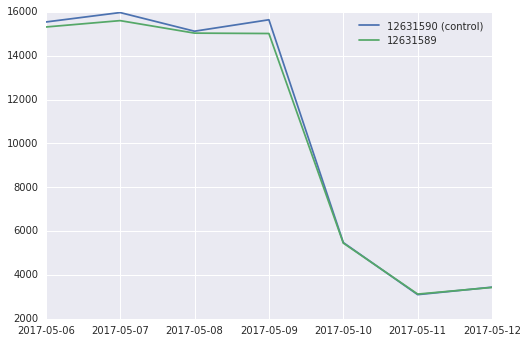

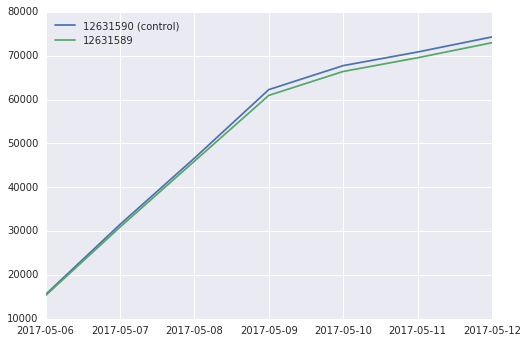

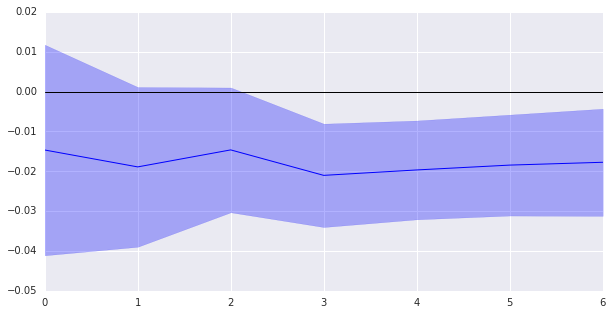

In [13]:
#@title [NPU] {vertical-output: true}

PlotAll("New paying user",
          buyers.date,
          buyers.user_bucket,
          buyers.target_id, 
          buyers.npu_count,
          pandas.Series([0.05] * len(buyers.npu_count)))

metric: Buyer Week
Cumulative uplift for group 12631589: 0.02%
Treatment 12631589
  Jackkinfe confidence interval: [-0.28%, 0.32%]
  Cumulative uplift: 0.02%
  Statistical significance: NO


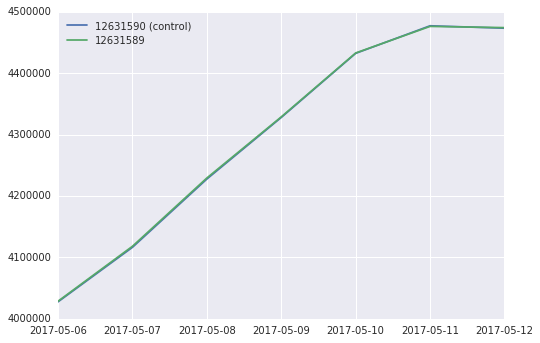

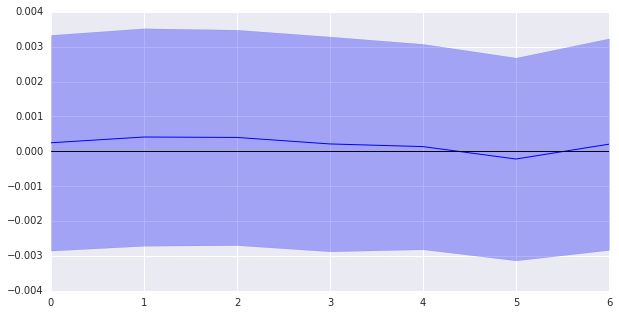

In [14]:
#@title [Buyer weeks] {vertical-output: true}

PlotBuyerWeek("Buyer Week",
          buyer_weeks.date, 
          buyer_weeks.user_bucket,
          buyer_weeks.target_id,
          buyer_weeks.buyer_weeks,
          pandas.Series([0.05] * len(buyer_weeks.buyer_weeks)))